In [1]:
from transformers import Wav2Vec2Model, Wav2Vec2FeatureExtractor
import torch
import librosa
import matplotlib.pyplot as plt
import os
import numpy as np

In [2]:
dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# dev = 'cpu'

In [3]:
feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained(
    "facebook/hubert-base-ls960"
)

In [4]:
sr = feature_extractor.sampling_rate
print(sr)

16000


In [5]:
base_model = Wav2Vec2Model.from_pretrained("facebook/hubert-base-ls960", torch_dtype=torch.float16).to(dev)

You are using a model of type hubert to instantiate a model of type wav2vec2. This is not supported for all configurations of models and can yield errors.
Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/hubert-base-ls960 and are newly initialized: ['encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'encoder.pos_conv_embed.conv.parametrizations.weight.original1']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
base_model.feature_extractor

Wav2Vec2FeatureEncoder(
  (conv_layers): ModuleList(
    (0): Wav2Vec2GroupNormConvLayer(
      (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
      (activation): GELUActivation()
      (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
    )
    (1-4): 4 x Wav2Vec2NoLayerNormConvLayer(
      (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
      (activation): GELUActivation()
    )
    (5-6): 2 x Wav2Vec2NoLayerNormConvLayer(
      (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
      (activation): GELUActivation()
    )
  )
)

In [7]:
# bring test audio data
audio_folder = '/media/maximos/9C33-6BBD/data/melos_singers/Rebetika_vowels/train/Bellou/'
audio_paths = os.listdir( audio_folder )
print(audio_paths)

['Bellou_a_2.mp3', 'Bellou_a_3.mp3', 'Bellou_a_4.mp3', 'Bellou_a_5.mp3', 'Bellou_a_6.mp3', 'Bellou_a_7.mp3', 'Bellou_a_8.mp3', 'Bellou_e_2.mp3', 'Bellou_e_3.mp3', 'Bellou_e_4.mp3', 'Bellou_e_5.mp3', 'Bellou_i_2.mp3', 'Bellou_i_3.mp3', 'Bellou_i_4.mp3', 'Bellou_i_5.mp3', 'Bellou_i_6.mp3', 'Bellou_i_7.mp3', 'Bellou_u_2.mp3', 'Bellou_u_3.mp3', 'Bellou_u_4.mp3', 'Bellou_u_5.mp3', 'Bellou_w_2.mp3', 'Bellou_w_3.mp3', 'Bellou_w_4.mp3', 'Bellou_w_5.mp3', 'Bellou_w_6.mp3', 'Bellou_w_7.mp3', 'Bellou_w_8.mp3']


In [8]:
audio_path = audio_folder + audio_paths[0]
audio_var, _ = librosa.load(audio_path, sr=sr)

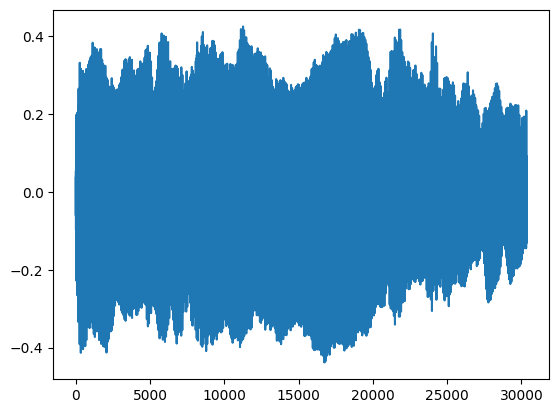

In [9]:
plt.plot(audio_var)

In [10]:
audio_input = feature_extractor(audio_var, sampling_rate=sr,return_attention_mask=True)

In [11]:
print(audio_input)
print(audio_input['input_values'][0].shape)

{'input_values': [array([ 0.25117874,  0.05256063, -0.3135493 , ...,  0.23747332,
       -0.2778735 ,  0.00069482], dtype=float32)], 'attention_mask': [array([1, 1, 1, ..., 1, 1, 1], dtype=int32)]}
(30360,)


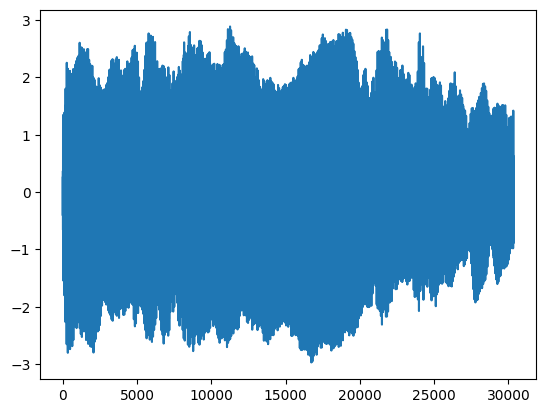

In [12]:
plt.plot(audio_input['input_values'][0])

In [13]:
audio_vars = []
for audio_path in audio_paths:
    audio_var, _ = librosa.load(audio_folder + audio_path, sr=sr)
    audio_vars.append(audio_var)

In [22]:
audio_normalized = feature_extractor(audio_vars, sampling_rate=sr,padding=True, return_attention_mask=True,)

In [15]:
print(audio_normalized['input_values'][2].shape)

(33414,)


In [16]:
audio_tensors = torch.from_numpy(np.array(audio_normalized['input_values']))

In [17]:
print(audio_tensors.shape)

torch.Size([28, 33414])


In [23]:
attention_mask = torch.from_numpy(np.array(audio_normalized['attention_mask']))

In [24]:
y = base_model(
    audio_tensors[:8,:].half().to(dev),
    attention_mask=attention_mask[:8,:].half().to(dev),
)

In [25]:
print(y['last_hidden_state'].shape)
# print(y)

torch.Size([8, 104, 768])


In [26]:
print(base_model.config.hidden_size)

768


In [27]:
pooled_y = y['last_hidden_state'].mean(axis=1)
print(pooled_y.shape)

torch.Size([8, 768])
